In [28]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

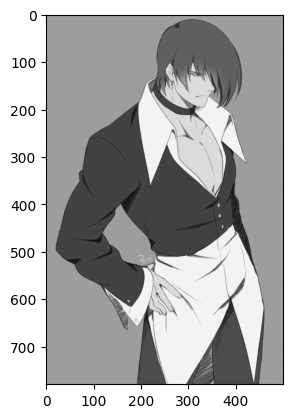

In [29]:
image = plt.imread("IoriYagami.jpg")
gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [ ]:
[20][30][49]


In [30]:
LPF = np.array([0.7071, 0.7071])
HPF = np.array([-0.7071, 0.7071])

In [31]:
def rowFiltering(img,kernel):
     imagePadding = np.pad(img,([0,0],[0,int(len(kernel)/2)]), 'constant', constant_values=0)
     result = np.zeros(img.shape).astype(int)
     for i in range(img.shape[0]):
          for j in range(img.shape[1]):
               for row in range(len(kernel)):
                    result[i,j] += kernel[row] * imagePadding[i,j+row]
     return result

def colFiltering(img,kernel):
     imagePadding = np.pad(img,([0,int(len(kernel)/2)],[0,0]), 'constant', constant_values=0)
     result = np.zeros(img.shape).astype(int)
     for i in range(img.shape[0]):
          for j in range(img.shape[1]):
               for col in range(len(kernel)):
                    result[i,j] += kernel[col] * imagePadding[i+col,j]
     return result


In [32]:
#For Decomposition
def colDownSampling(img):
     result = np.zeros((img.shape[0],img.shape[1]//2)).astype(int)
     for i in range(img.shape[0]):
          index = 0
          for j in range(img.shape[1]//2):
               result[i][j] = img[i][index]
               index += 2
     return result
def rowDownSampling(img):
     result = np.zeros((img.shape[0]//2,img.shape[1])).astype(int)
     index = 0
     for i in range(img.shape[0]//2):
          for j in range(img.shape[1]):
               result[i][j] = img[index][j]
          index += 2
     return result

# For Reconstruction
def rowUpSampling(img):
     result = np.zeros((img.shape[0]*2,img.shape[1])).astype(int)
     index = 0
     for i in range(img.shape[0]):
          for j in range(img.shape[1]):
               result[index][j] = img[i][j]
               result[index+1][j] = img[i][j]
          index += 2
     return result
def colUpSampling(img):
     result = np.zeros((img.shape[0],img.shape[1]*2)).astype(int)
     for i in range(img.shape[0]):
          index = 0
          for j in range(img.shape[1]):
               result[i][index] = img[i][j]
               result[i][index+1] = img[i][j]
               index += 2
     return result

In [33]:
def pad_image(image, level):
     pad_size = 2**level
     pad_height = pad_size - (image.shape[0] % pad_size) if image.shape[0] % pad_size != 0 else 0
     pad_width = pad_size - (image.shape[1] % pad_size) if image.shape[1] % pad_size != 0 else 0
     padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='edge')
     return padded_image

def normalize(data, min_target, max_target):
     min_val = np.min(data)
     max_val = np.max(data)
     return (data - min_val) / (max_val - min_val) * (max_target - min_target) + min_target

def plotSignal(citra, judul, warna='b', gaya_garis='-', marker=None):
     vektor = np.ravel(citra)
     plt.figure(figsize=(12, 6))
     plt.plot(vektor, color=warna, linestyle=gaya_garis, marker=marker)
     plt.title(judul)
     plt.xlabel('Indeks')
     plt.ylabel('Amplitudo')
     plt.show()

In [34]:
def decompositionProcess (img, filter1, filter2):
     stage1 = rowFiltering(img,filter1)
     stage2 = colDownSampling(stage1)

     stage3 = colFiltering(stage2, filter2)
     stage4 = rowDownSampling(stage3)

     result = normalize(stage4,0,255).astype(int)
     return result

def decompositionLevel(img, LPF, HPF, level, showResult):
     if level == 0:
          return img

     approximate = decompositionProcess(img, LPF, LPF)
     horizontal = decompositionProcess(img, LPF, HPF)
     vertical = decompositionProcess(img, HPF, LPF)
     diagonal = decompositionProcess(img, HPF, HPF)

     result = np.vstack((np.hstack((approximate, horizontal)), np.hstack((vertical, diagonal))))
     if showResult:
          if level > 1:
               approximate, horizontal, vertical, diagonal, result = decompositionLevel(approximate, LPF, HPF, level - 1,showResult)
               return approximate, horizontal, vertical, diagonal, result
          else:
               return approximate, horizontal, vertical, diagonal, result
     else:
          if level > 1:
               approximate,_,_,_,_ = decompositionLevel(approximate, LPF, HPF, level - 1, showResult)

               resizedH = np.resize(horizontal,(approximate.shape[0],approximate.shape[1]))
               resizedV = np.resize(vertical,  (approximate.shape[0],approximate.shape[1]))
               resizedD = np.resize(diagonal,  (approximate.shape[0],approximate.shape[1]))

               approximate = np.vstack((np.hstack((approximate, resizedH)), np.hstack((resizedV, resizedD))))
               result = np.vstack((np.hstack((approximate, horizontal)), np.hstack((vertical, diagonal))))
          return approximate, horizontal, vertical, diagonal, result

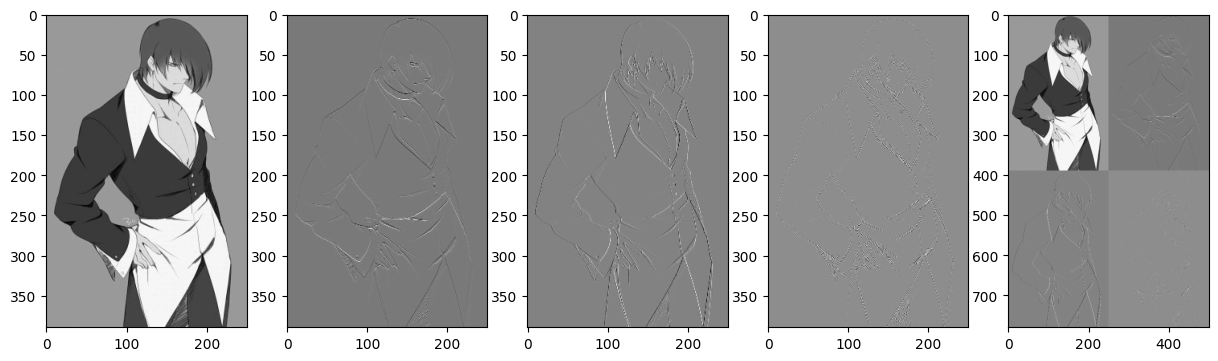

In [35]:
aprox, horiz, verti, diago, combine = decompositionLevel(gray, LPF, HPF, 1, True)

plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(aprox,cmap="gray")
plt.subplot(1,5,2)
plt.imshow(horiz,cmap="gray")
plt.subplot(1,5,3)
plt.imshow(verti,cmap="gray")
plt.subplot(1,5,4)
plt.imshow(diago,cmap="gray")
plt.subplot(1,5,5)
plt.imshow(combine,cmap="gray")

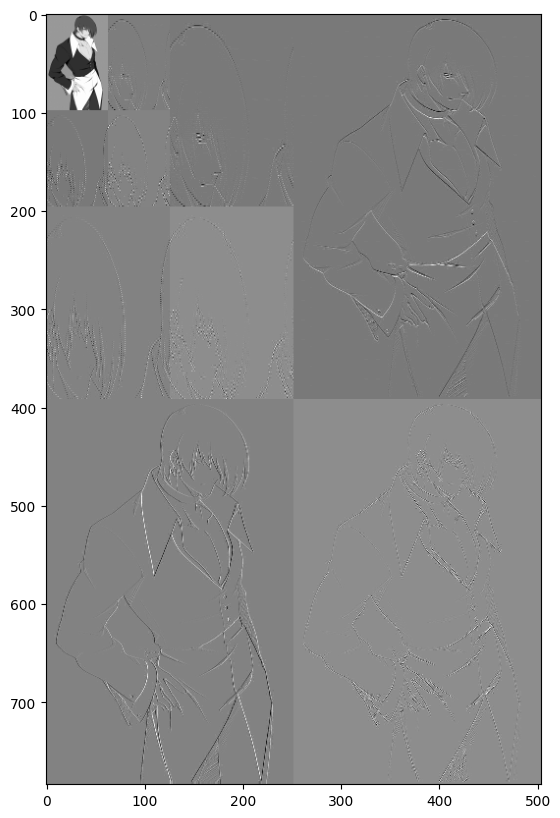

In [36]:
padImg = pad_image(gray, 5)
_,_,_,_,result = decompositionLevel(padImg,LPF,HPF,5, False)
plt.figure(figsize=(10,10))
plt.imshow(result,cmap="gray")

In [46]:
def reconstruction(ap, dv, dh, dd):
    aprox = rowUpSampling(ap)
    horiz = rowUpSampling(dv)
    verti = rowUpSampling(dh)
    diago = rowUpSampling(dd)

    convLow  = colFiltering(aprox, LPF)
    convHigh = colFiltering(horiz, HPF)
    LowHigh = colUpSampling(convLow + convHigh)

    result1 = rowFiltering(LowHigh,LPF)

    convLow  = colFiltering(verti, LPF)
    convHigh = colFiltering(diago, HPF)
    LowHigh = colUpSampling(convLow + convHigh)

    result2 = rowFiltering(LowHigh,HPF)

    result = result1 + result2
    result = normalize(result,0,255)
    return result

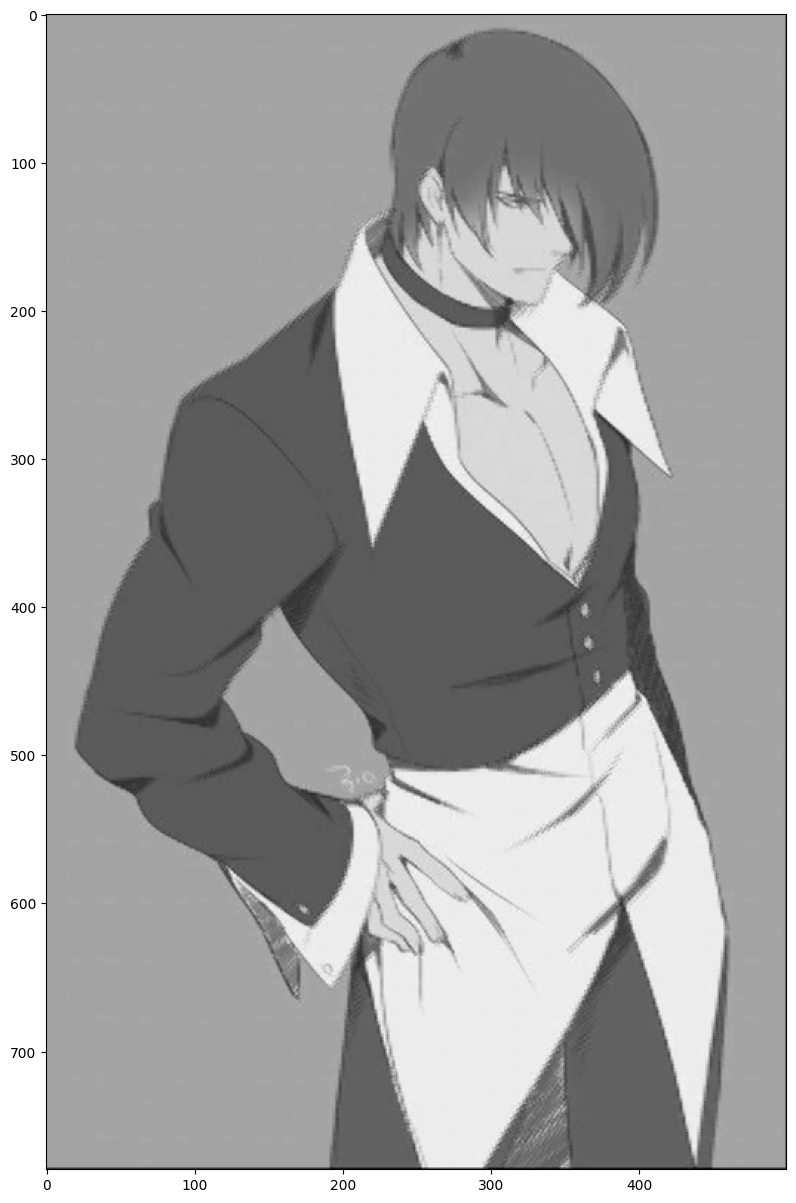

In [47]:
test = reconstruction(aprox, verti, horiz, diago)
plt.figure(figsize=(15,15))
plt.imshow(test,cmap="gray")

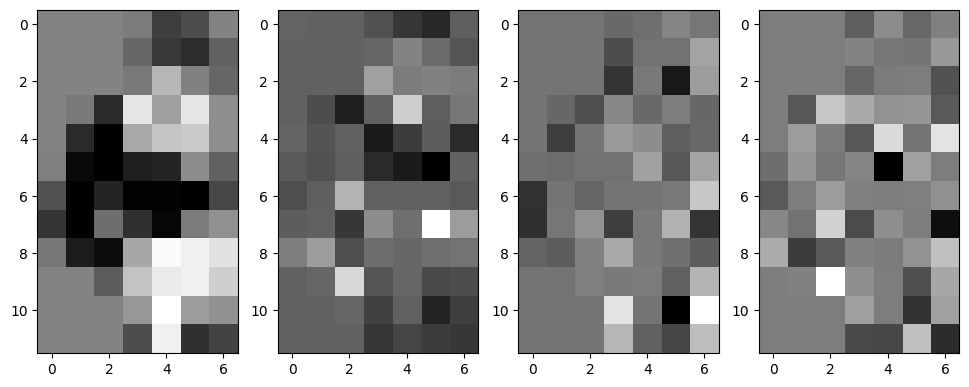

In [39]:
LL,HL,LH,HH,_ = decompositionLevel(gray,LPF,HPF,6,True)

plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(LL,cmap="gray")
plt.subplot(1,5,2)
plt.imshow(HL,cmap="gray")
plt.subplot(1,5,3)
plt.imshow(LH,cmap="gray")
plt.subplot(1,5,4)
plt.imshow(HH,cmap="gray")

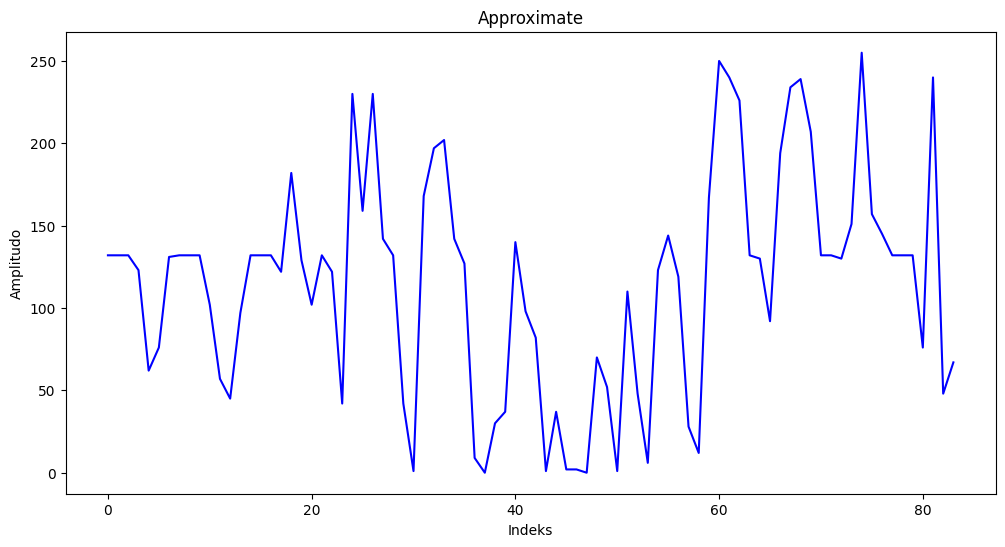

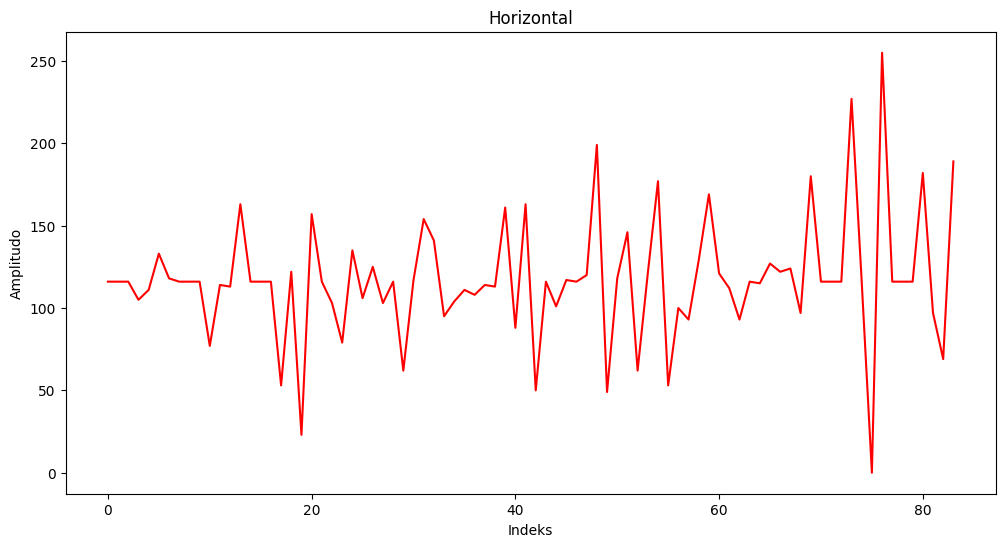

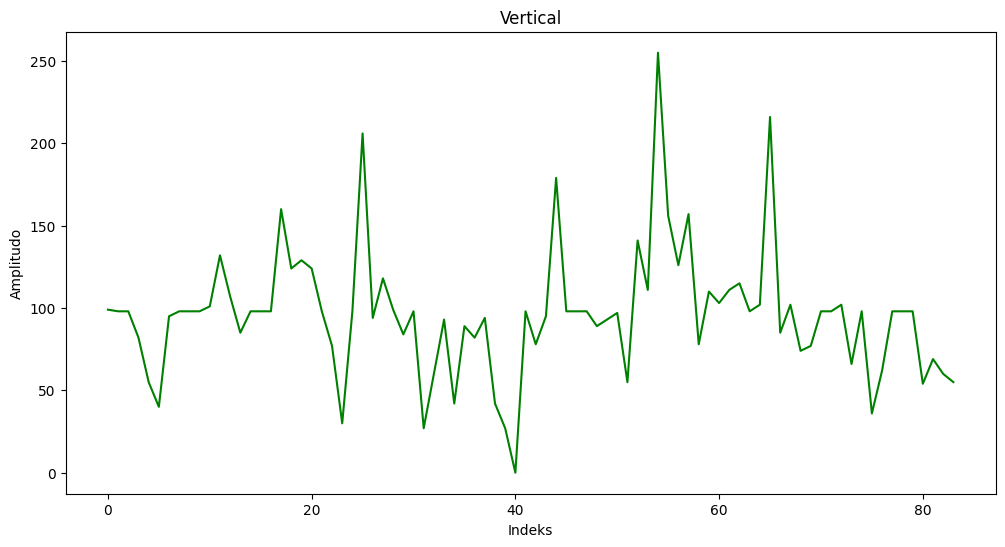

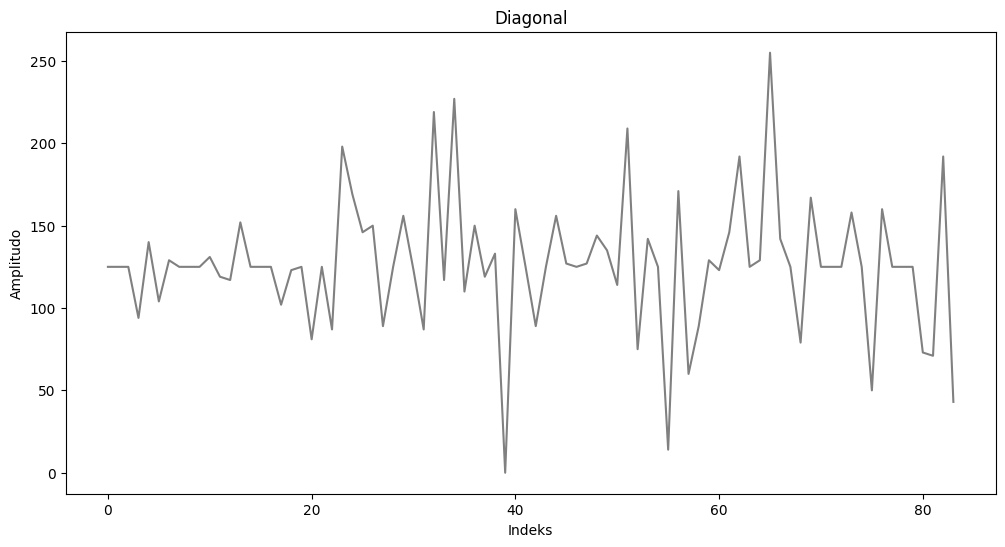

In [40]:
plotSignal(LL,"Approximate")
plotSignal(LH,"Horizontal", "r")
plotSignal(HL,"Vertical", "g")
plotSignal(HH,"Diagonal", "gray")
